In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test, ttest_1samp, chi2_contingency, ttest_ind, f_oneway

import re
from nltk.tokenize import word_tokenize

ModuleNotFoundError: No module named 'nltk'

In [71]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

In [3]:
FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv")
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv")
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

event_table["date"] = pd.to_datetime(event_table["date"])
full_table["date"] = pd.to_datetime(full_table["date"])

In [4]:
# Common Slices
illegal_decks = full_table[
    ~full_table["cardId"].isin(card_table[card_table["standardLegality"] == "legal"]["cardId"])
]["deckId"]

first_place_decks = deck_table[
    (deck_table["rank"] == 1)
    & ~(deck_table["deckId"].isin(illegal_decks))
].copy()
main_decks = full_table[
    (~full_table["name"].isin(["Island", "Mountain", "Forest", "Plains", "Swamp"]))
    & (full_table["slot"] == "md")
    & ~(full_table["deckId"].isin(illegal_decks))
].copy()


In [62]:
def get_most_used_cards():
    grouped_table = (
        main_decks
        .copy()
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(main_decks["deckId"].nunique())
    
    return grouped_table

In [63]:
most_used_cards = get_most_used_cards()

In [64]:
most_used_cards

,name,deckId,pct_total
195,Fabled Passage,1696,0.690835
69,Bonecrusher Giant // Stomp,1093,0.445214
557,"Shatterskull Smashing // Shatterskull, the Hammer Pass",997,0.406110
366,Lovestruck Beast // Heart's Desire,933,0.380041
329,Kazandu Mammoth // Kazandu Valley,916,0.373116
...,...,...,...
570,Skull Raid,1,0.000407
106,Concerted Defense,1,0.000407
191,Excavation Mole,1,0.000407
574,Skyclave Pick-Axe,1,0.000407


In [5]:
deck_table.head()

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,gruul
1,2,1,4,?e=27938&d=421598&f=ST,UW Control,2,control,azorius
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,mono red
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,rakdos
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,gruul


In [6]:
card_table.head()

,setNumber,setName,name,cmc,color,mana_cost,standardLegality,oracle_text,cardId
0,001,eld,Acclaimed Contender,3,W,{2}{W},legal,"When Acclaimed Contender enters the battlefield, if you control another Knight, look at the top five cards of your library. You may reveal a Knight, Aura, Equipment, or legendary artifact card from among them and put it into your hand. Put the rest on the bottom of your library in a random order.",001eld
1,002,eld,All That Glitters,2,W,{1}{W},legal,Enchant creature\nEnchanted creature gets +1/+1 for each artifact and/or enchantment you control.,002eld
2,003,eld,Archon of Absolution,4,W,{3}{W},legal,"Flying\nProtection from white (This creature can't be blocked, targeted, dealt damage, enchanted, or equipped by anything white.)\nCreatures can't attack you or a planeswalker you control unless their controller pays {1} for each of those creatures.",003eld
3,004,eld,Ardenvale Paladin,4,W,{3}{W},legal,"Adamant — If at least three white mana was spent to cast this spell, Ardenvale Paladin enters the battlefield with a +1/+1 counter on it.",004eld
4,005,eld,Ardenvale Tactician // Dizzying Swoop,3,W,{1}{W}{W} // {1}{W},legal,Flying // Tap up to two target creatures. (Then exile this card. You may cast the creature later from exile.),005eld


In [7]:
first_place_decks.head()

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,gruul
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,mono red
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,rakdos
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,gruul
12,13,5,15,?e=27918&d=421478&f=ST,Rakdos Control,1,control,rakdos


In [8]:
(event_table.head())

,eventId,name,link,date,latest_set
0,1,FNM @ MTG Arena Campania,https://www.mtgtop8.com/event?e=27938&f=ST,2020-10-30,Zendikar Rising
1,2,Torneios @ Ludo Quest,https://www.mtgtop8.com/event?e=27939&f=ST,2020-10-30,Zendikar Rising
2,3,All Hallow's Eve FNM @ Gamer's Gauntlet,https://www.mtgtop8.com/event?e=27940&f=ST,2020-10-30,Zendikar Rising
3,4,Japan Championship 2020 Autumn Last Chance Trial @ BIG Magic,https://www.mtgtop8.com/event?e=27925&f=ST,2020-10-29,Zendikar Rising
4,5,Free Daily @ Owl Central Games,https://www.mtgtop8.com/event?e=27918&f=ST,2020-10-28,Zendikar Rising


In [9]:
full_table.head()

,eventId,name_event,date,deckId,pilotId,name_deck,firstName,lastName,cardId,name,count,color,slot,archetype,category,latest_set
0,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,261znr,Cragcrown Pathway // Timbercrown Pathway,4,GR,md,aggro,gruul,Zendikar Rising
1,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,244eld,Fabled Passage,4,NaN,md,aggro,gruul,Zendikar Rising
2,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,266eld,Forest,9,G,md,aggro,gruul,Zendikar Rising
3,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,262eld,Mountain,5,R,md,aggro,gruul,Zendikar Rising
4,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,115eld,Bonecrusher Giant // Stomp,4,R,md,aggro,gruul,Zendikar Rising


In [10]:
full_table[~full_table["name_event"].str.contains("Arena")]

,eventId,name_event,date,deckId,pilotId,name_deck,firstName,lastName,cardId,name,count,color,slot,archetype,category,latest_set
53,2,Torneios @ Ludo Quest,2020-10-30,3,5,Red Deck Wins,Ricardo,Azeredo,262eld,Mountain,16,R,md,aggro,mono red,Zendikar Rising
54,2,Torneios @ Ludo Quest,2020-10-30,3,5,Red Deck Wins,Ricardo,Azeredo,115eld,Bonecrusher Giant // Stomp,4,R,md,aggro,mono red,Zendikar Rising
55,2,Torneios @ Ludo Quest,2020-10-30,3,5,Red Deck Wins,Ricardo,Azeredo,137eld,Rimrock Knight // Boulder Rush,4,R,md,aggro,mono red,Zendikar Rising
56,2,Torneios @ Ludo Quest,2020-10-30,3,5,Red Deck Wins,Ricardo,Azeredo,161znr,"Shatterskull Smashing // Shatterskull, the Hammer Pass",3,R,md,aggro,mono red,Zendikar Rising
57,2,Torneios @ Ludo Quest,2020-10-30,3,5,Red Deck Wins,Ricardo,Azeredo,120eld,Embercleave,4,R,md,aggro,mono red,Zendikar Rising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78050,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,147thb,Ox of Agonas,3,R,sb,control,grixis,Kaldheim
78051,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,058eld,Mystical Dispute,3,U,sb,control,grixis,Kaldheim
78052,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,096m21,Duress,4,B,sb,control,grixis,Kaldheim
78053,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,088iko,Extinction Event,3,B,sb,control,grixis,Kaldheim


In [11]:
def most_winning_archetypes():
    first_place_decks.loc[first_place_decks["archetype"] == "rogue", "archetype"] = "mill"
    grouped_archetypes = first_place_decks.groupby("archetype")["rank"].sum().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(12, 8))
#     sns.barplot(data=grouped_archetypes, x="archetype", y="rank")
    plt.bar(range(len(grouped_archetypes)), grouped_archetypes["rank"])
    plt.xticks(range(len(grouped_archetypes)), grouped_archetypes["archetype"], rotation=30)
    plt.title("Most Winning Archetypes")
    plt.show()

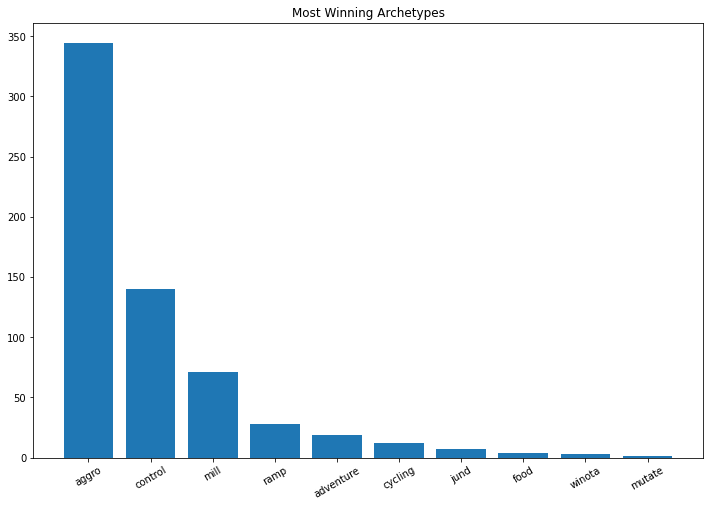

In [12]:
most_winning_archetypes()

In [13]:
def most_winning_colors(df):
    grouped_category = df.groupby("category")["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_category, x="category", y="rank")
    plt.title("Most Winning Colors")
    plt.xticks(rotation=30)
    plt.show()

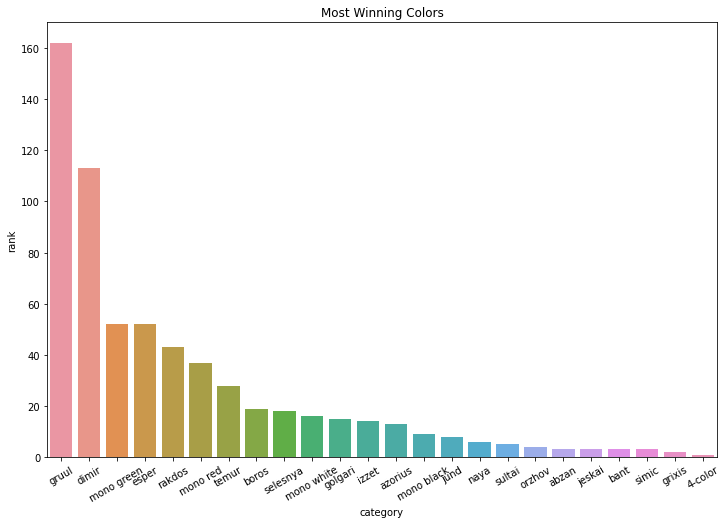

In [14]:
most_winning_colors(first_place_decks)

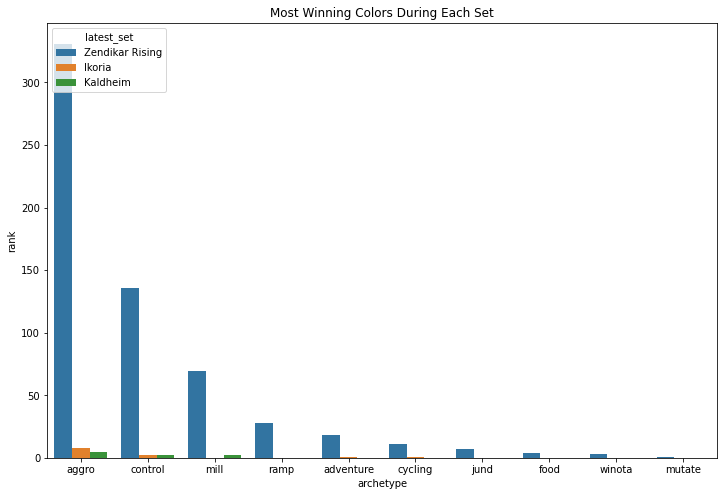

In [15]:
def most_winning_colors_by_set(df):
    merged_table = df.merge(event_table[["eventId", "latest_set"]], on="eventId", suffixes=[None, "_event"])
    grouped_table = merged_table.groupby(["archetype", "latest_set"])["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_table, x="archetype", y="rank", hue="latest_set")
    plt.title("Most Winning Colors During Each Set")
    plt.show()

most_winning_colors_by_set(first_place_decks)

In [16]:
def what_colors_go_with_archetype(archetypes, colors):
    archetypes = deck_table[deck_table["archetype"].isin(archetypes)]["archetype"]
    colors = deck_table[deck_table["category"].isin(colors)]["category"]
    frequencies = pd.crosstab(archetypes, colors)
    chi2, pval, _, expected = chi2_contingency(frequencies)
    return chi2, pval, frequencies, expected

what_colors_go_with_archetype(["aggro"], ["mono green", "gruul"])

(0.0,
 1.0,
 category   gruul  mono green
 archetype                   
 aggro        520         252,
 array([[520., 252.]]))

In [17]:
def colors_and_archetypes(df, archetype):
    df_archetype = df[df["archetype"] == archetype].copy()
    grouped_table = (
        df_archetype
        .groupby("category")["rank"]
        .count()
        .reset_index()
        .sort_values(by="rank", ascending=False)
    )
    plt.figure(figsize=(8, 5))
    sns.barplot(data=grouped_table, x="category", y="rank")
    plt.title(f"Categories in the Most Winning {archetype.title()} Decks")
    plt.xticks(rotation=30)
    plt.show()

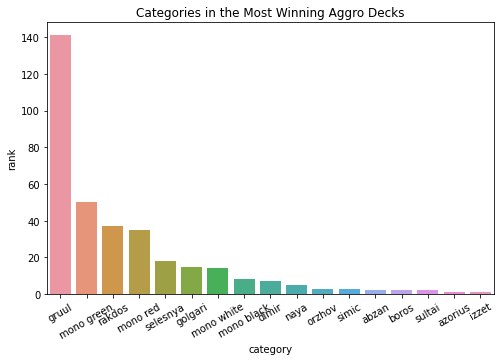

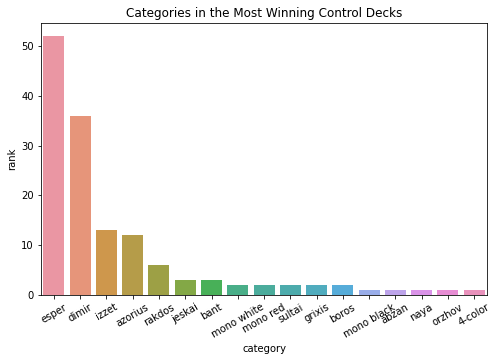

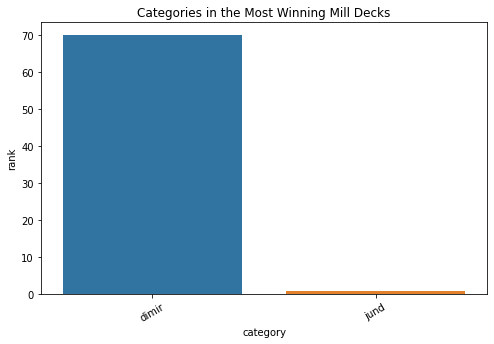

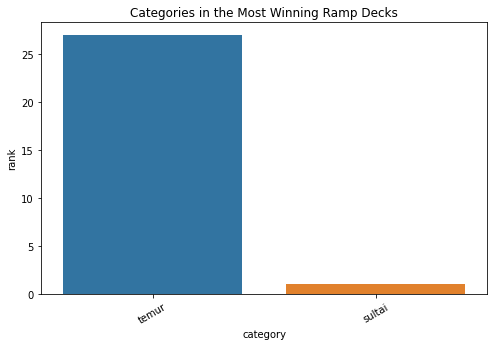

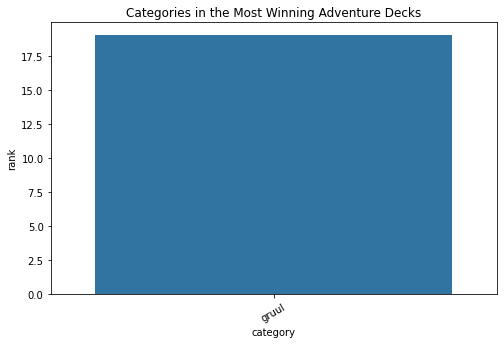

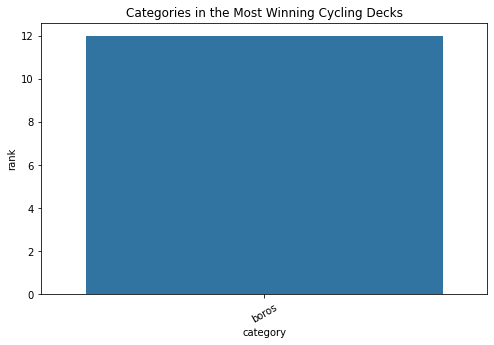

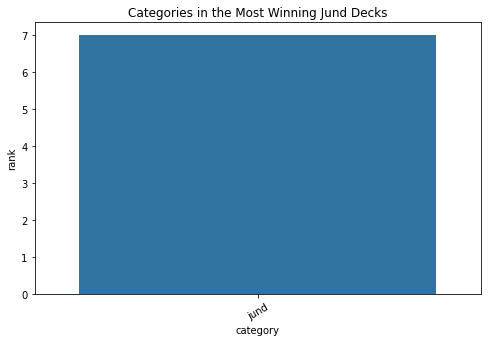

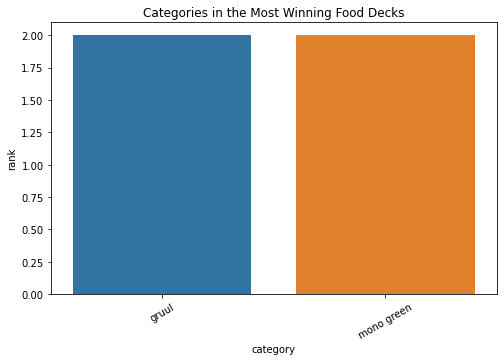

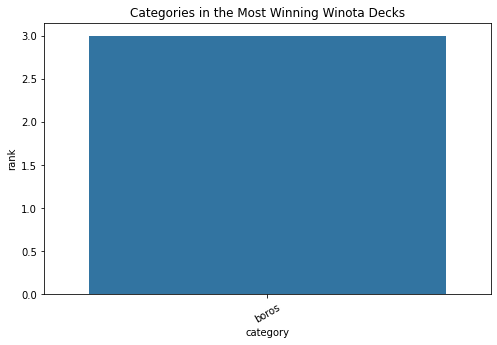

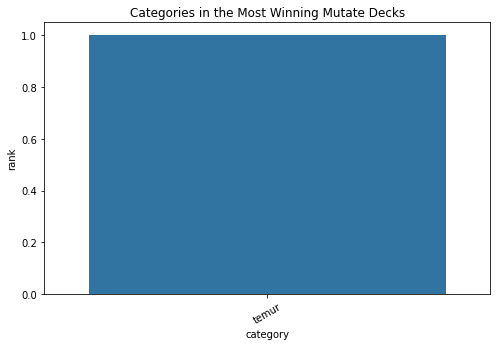

In [18]:
def top10_colors_archetypes(df):
    top10_archetypes = df["archetype"].value_counts().index[:10].tolist()
    for archetype in top10_archetypes:
        colors_and_archetypes(df, archetype)
#         plt.clf()

top10_colors_archetypes(first_place_decks)

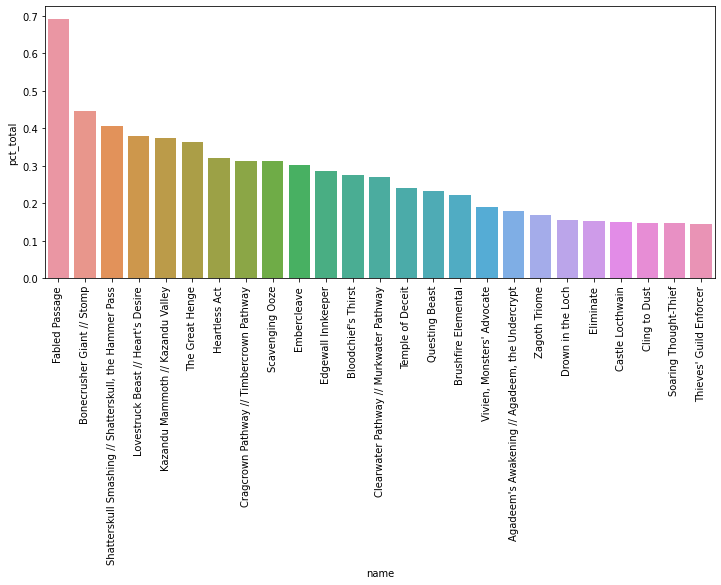

In [19]:
def most_used_cards(df):
    this_full_table = df.copy()
    grouped_table = (
        this_full_table
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(this_full_table["deckId"].nunique())
    plt.figure(figsize=(12, 5))
    sns.barplot(data=grouped_table.iloc[:25], x="name", y="pct_total")
    plt.xticks(rotation=90)
    plt.show()
    
most_used_cards(main_decks)

In [20]:
def most_used_cards_in_archetype(df, archetype):
    this_df = df[df["archetype"] == archetype].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(12, 5))
    sns.barplot(data=grouped_df.iloc[:30], x="name", y="pct_total")
    plt.xticks(rotation=90)
    plt.title(f"Most Used Cards in {archetype.title()} Decks")
    plt.ylabel("Percent of All Cards")
    plt.xlabel("")
    plt.show()

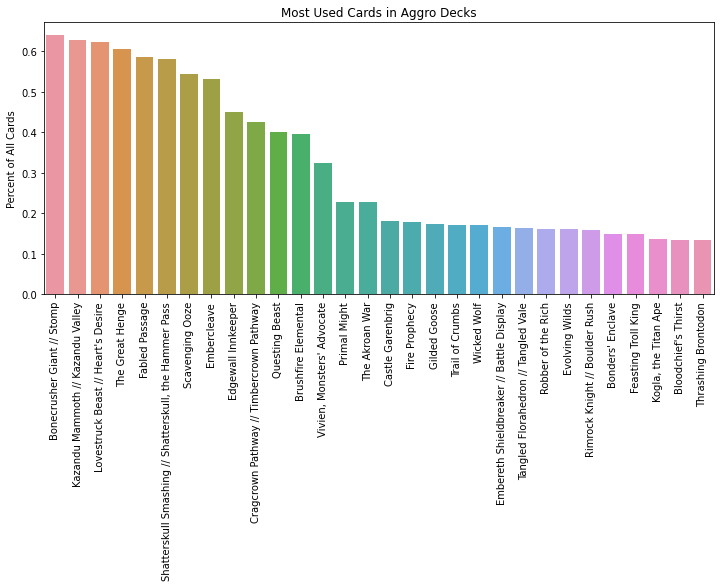

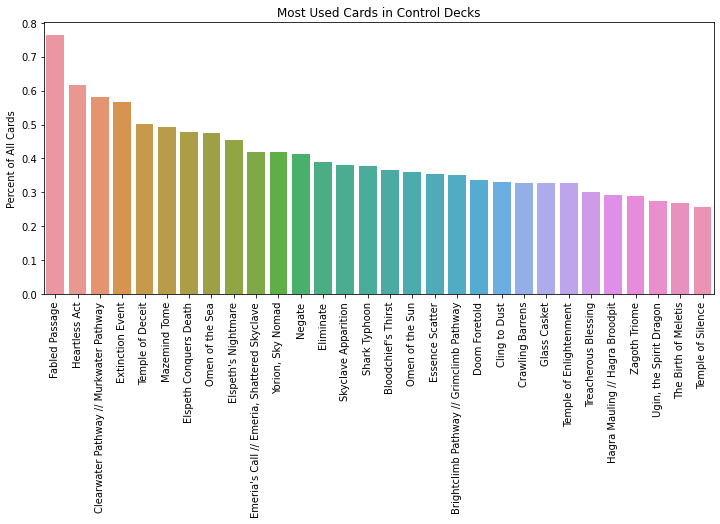

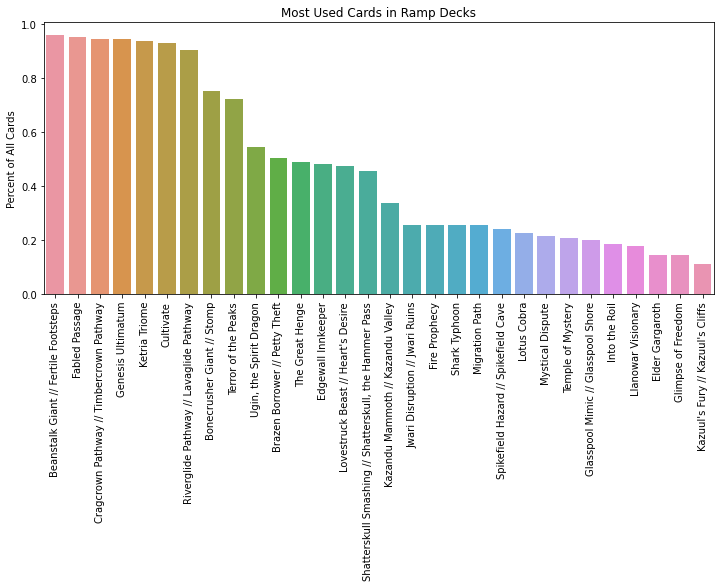

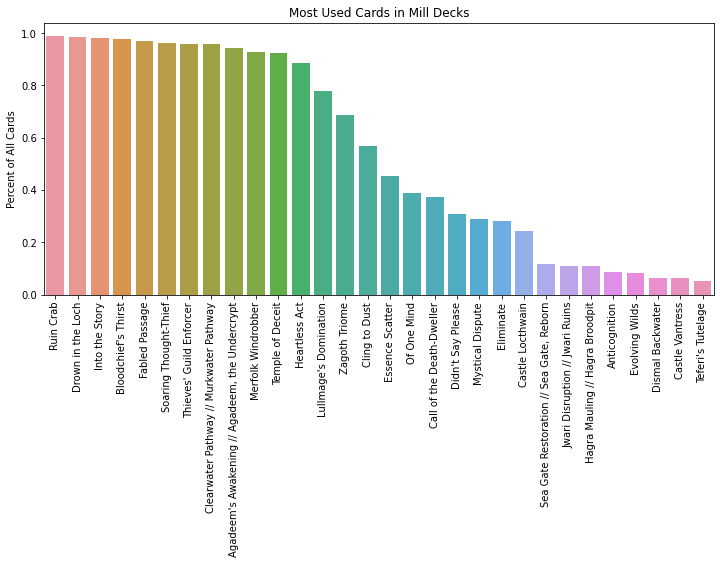

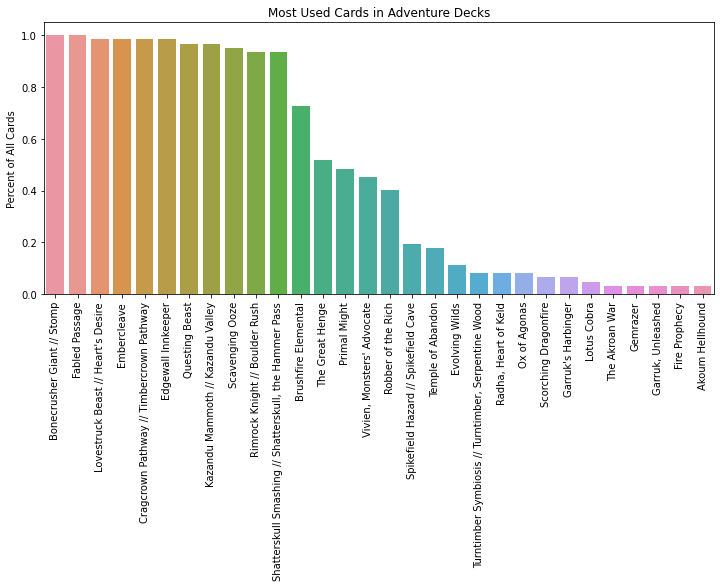

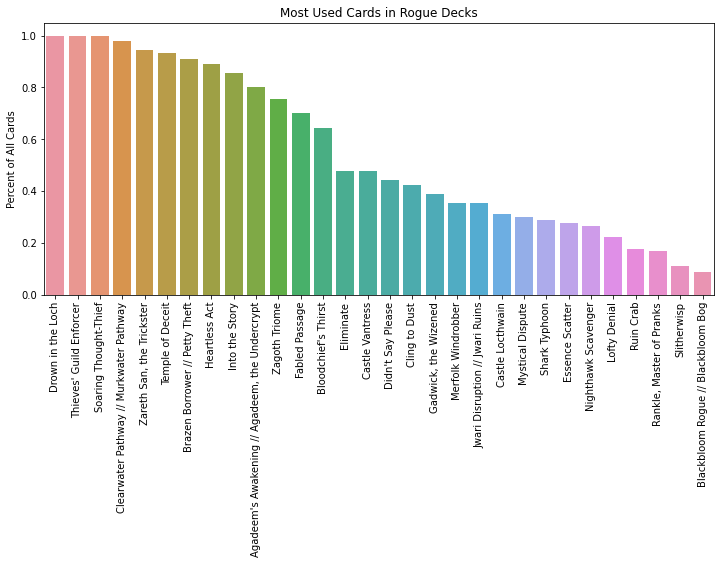

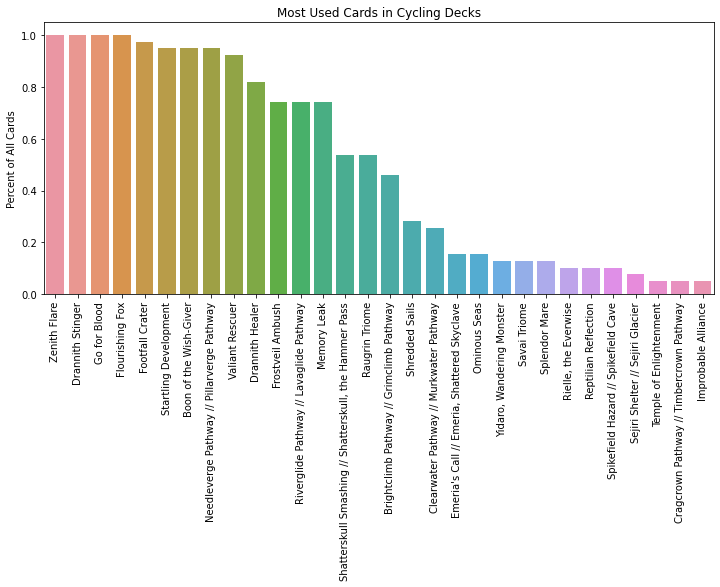

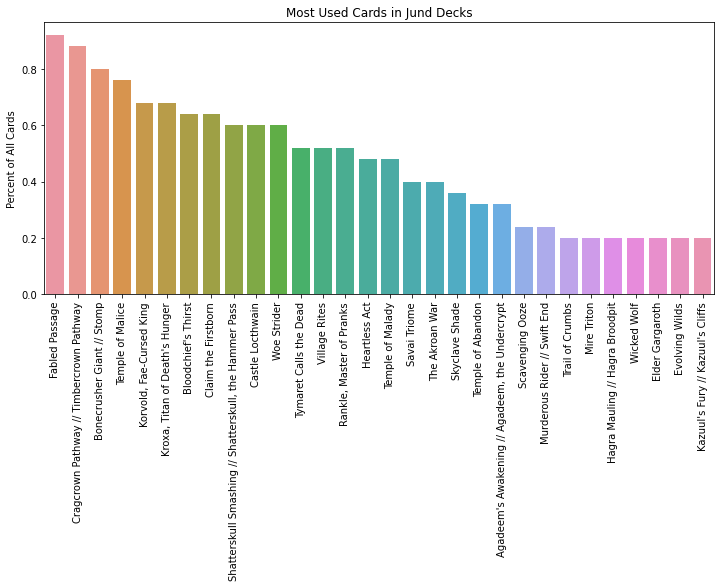

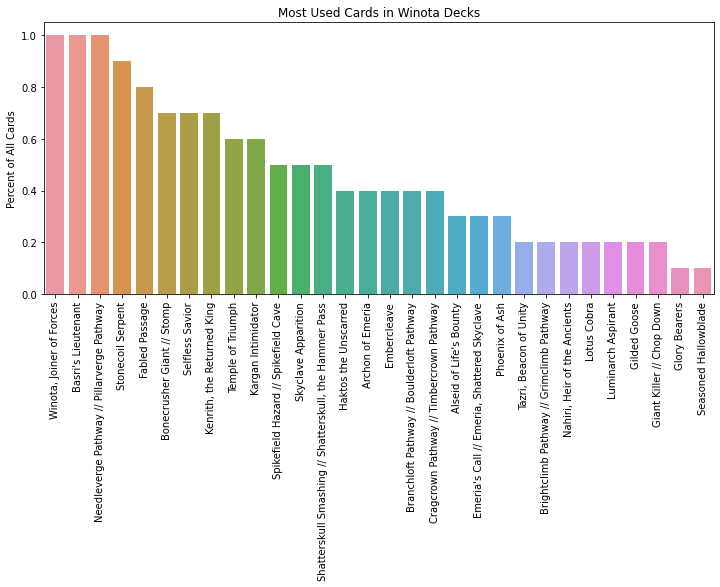

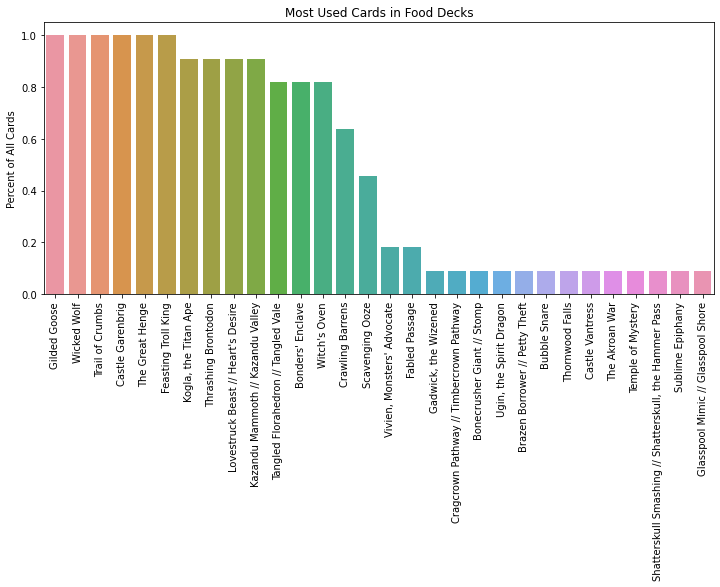

In [21]:
def top_10_archetypes(df):
    top_10_archetypes = deck_table["archetype"].value_counts().index[:10]
    for archetype in top_10_archetypes:
        most_used_cards_in_archetype(df, archetype)

top_10_archetypes(main_decks)

In [22]:
def most_used_cards_in_category(df, category):
    this_df = df[df["category"] == category].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(12, 5))
    sns.barplot(data=grouped_df.iloc[:25], x="name", y="pct_total")
    plt.title(f"The Top Cards for {category.title()} Decks")
    plt.ylabel("Percent of Total Cards")
    plt.xlabel("")
    plt.xticks(rotation=90)
    plt.show()

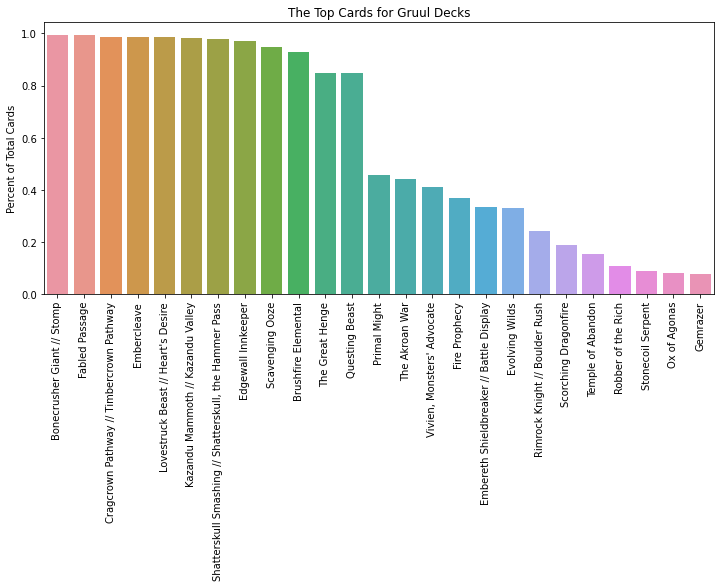

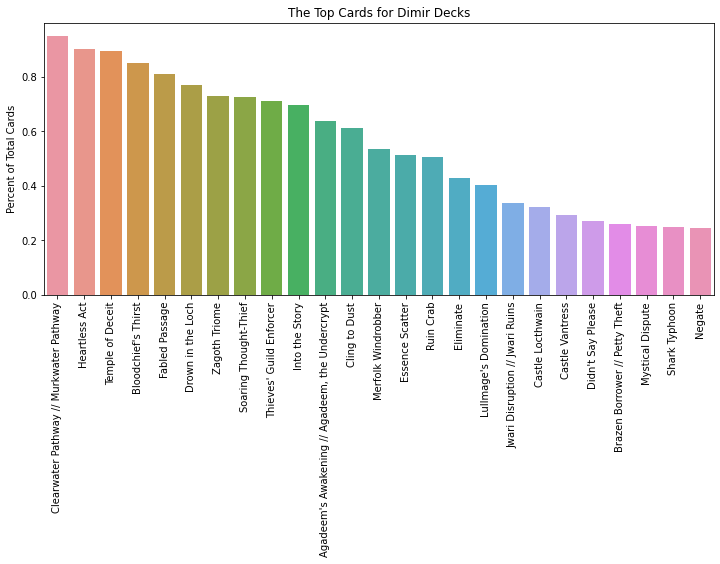

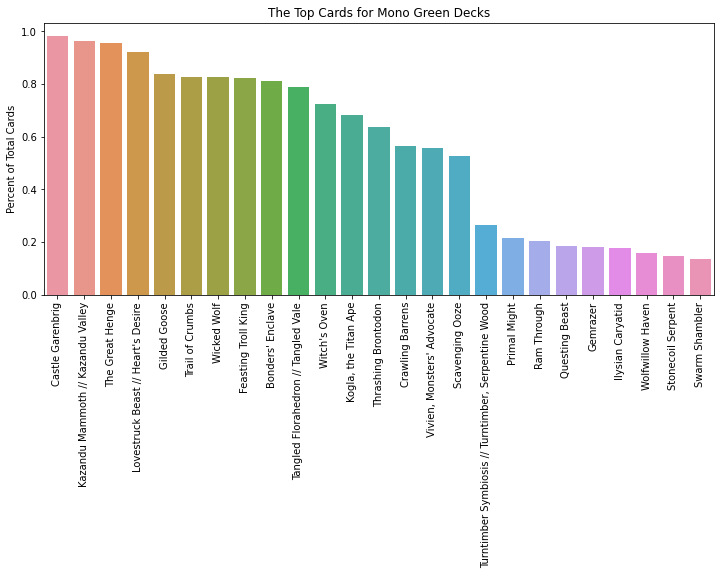

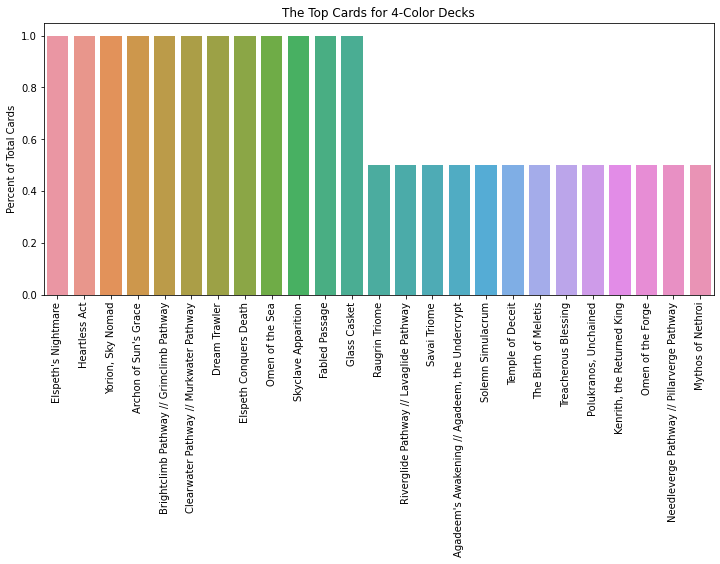

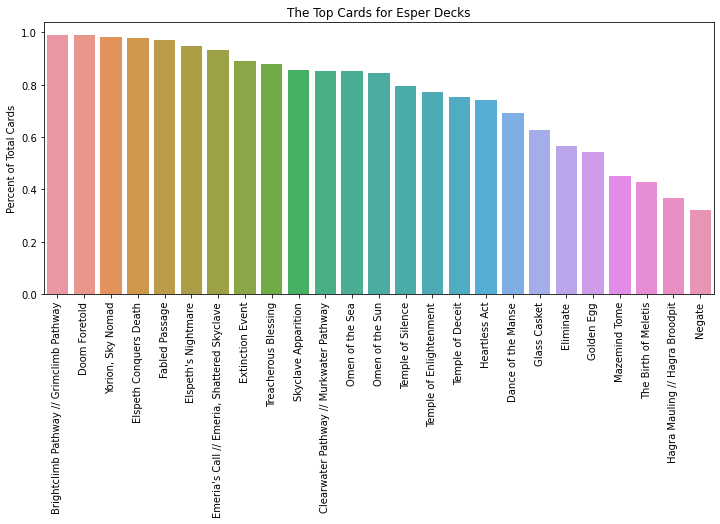

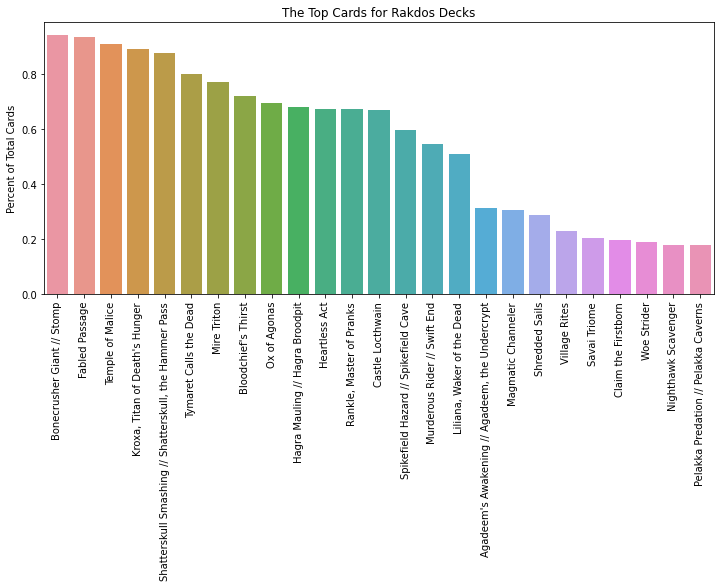

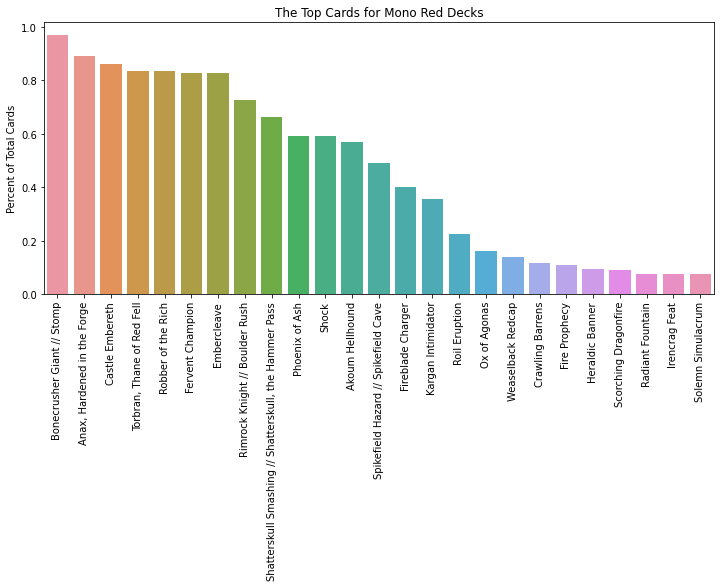

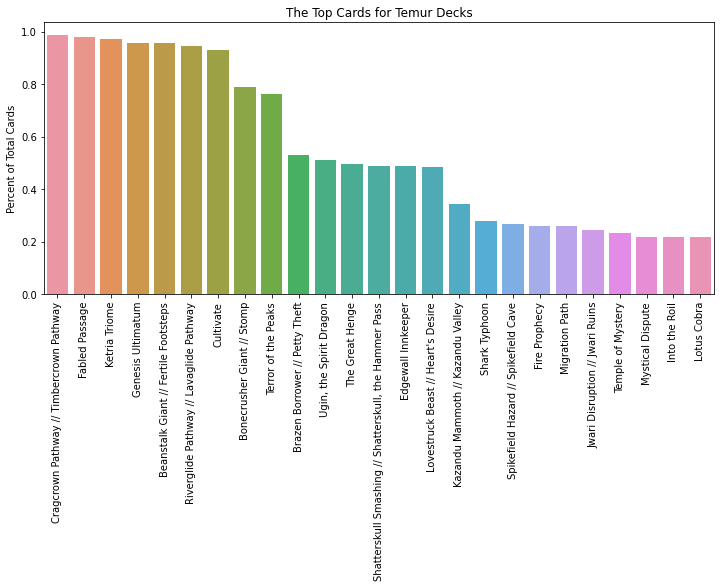

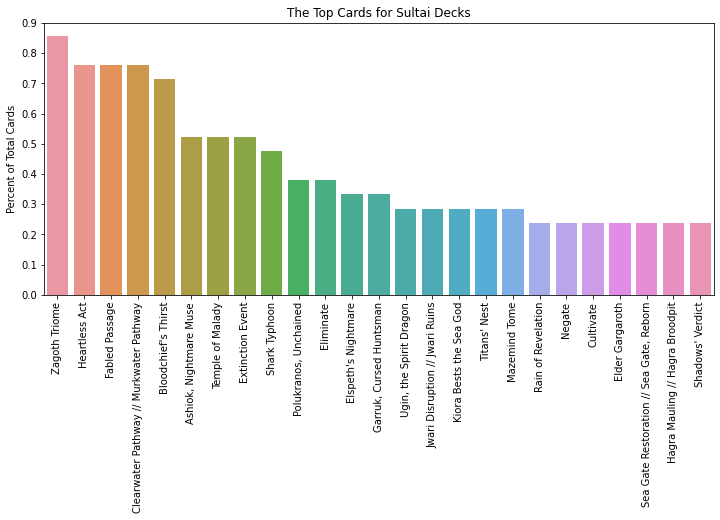

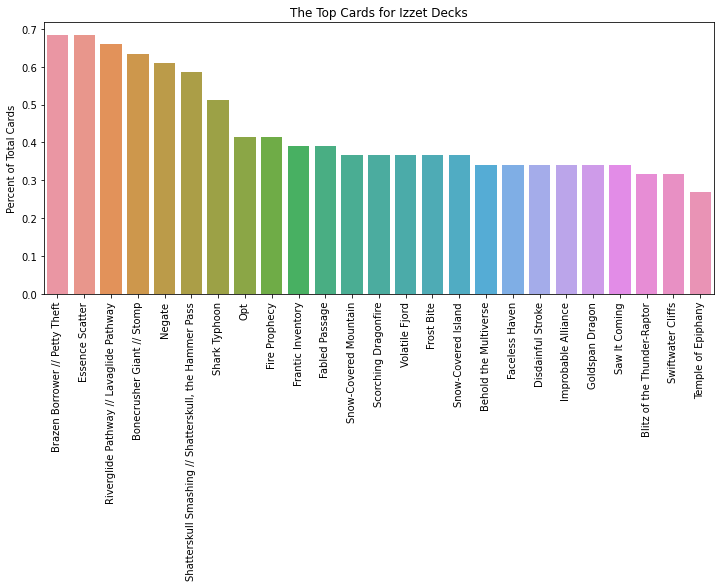

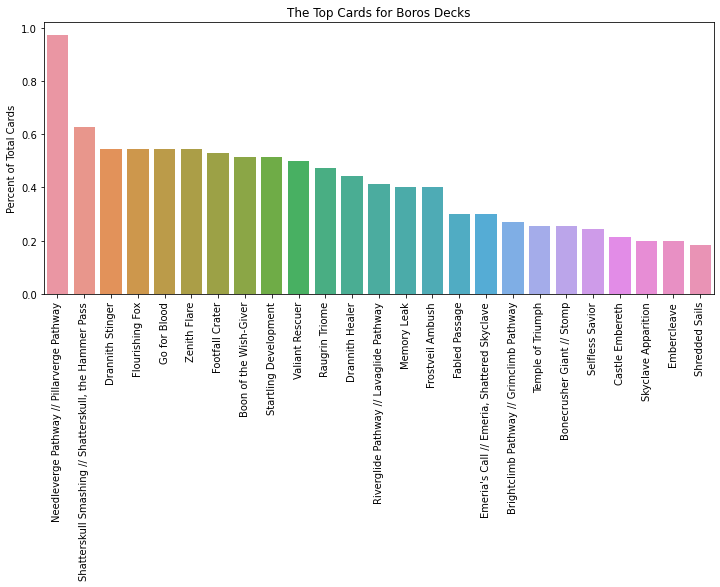

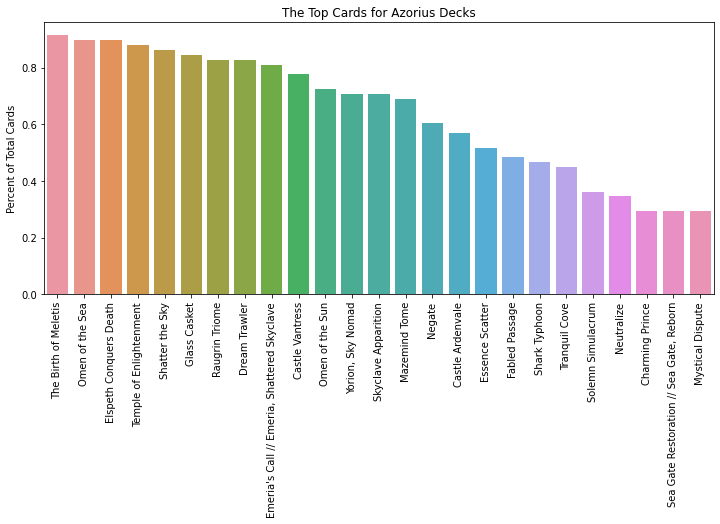

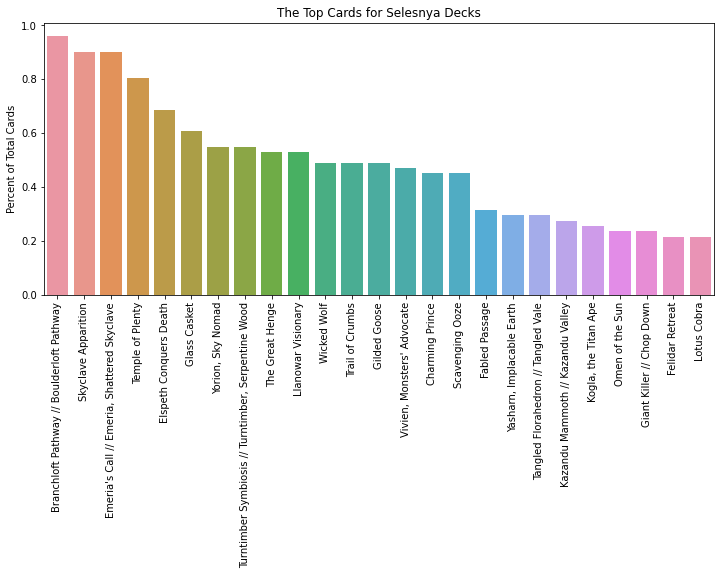

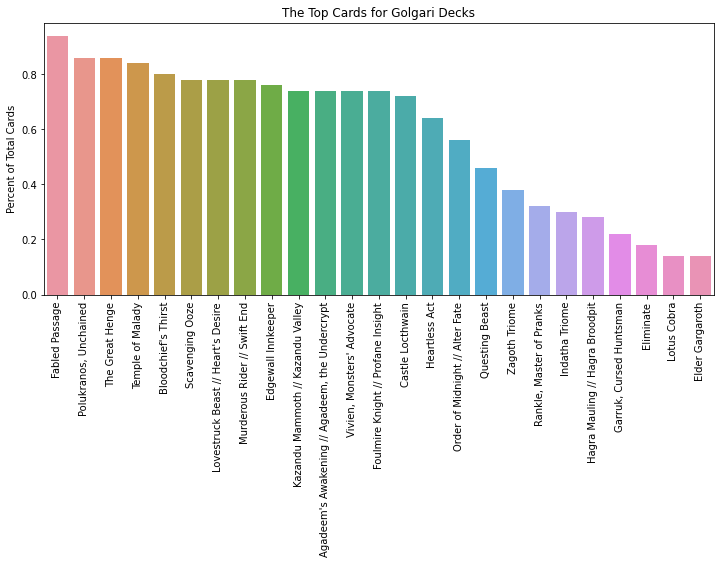

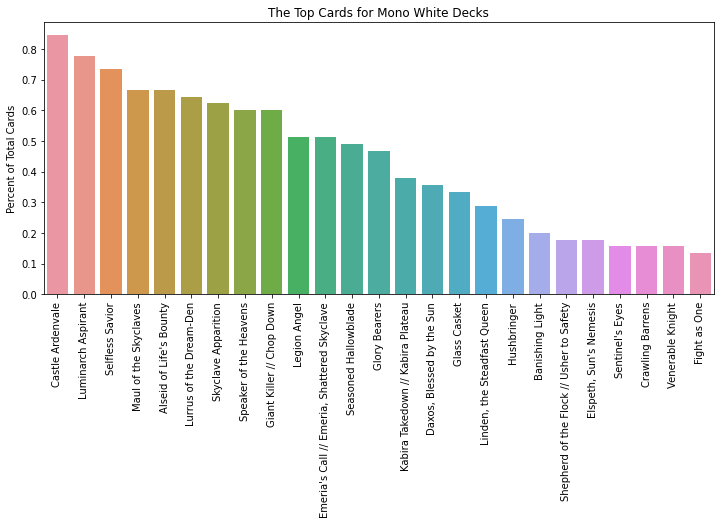

In [23]:
def top_15_categories(df):
    top_15_categories = deck_table["category"].value_counts().index[:15]
    for category in top_15_categories:
        most_used_cards_in_category(df, category)

top_15_categories(main_decks)

In [24]:
def cards_by_set(df, unique_cards=False):
    this_df = df[df["deckId"].isin(first_place_decks["deckId"])].copy()
    if unique_cards:
        this_df.drop_duplicates(subset="name", inplace=True)
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    sns.countplot(x=this_df["set"], order=this_df["set"].value_counts().index)
    plt.show()
    

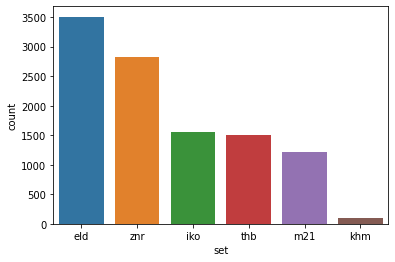

In [25]:
cards_by_set(main_decks)

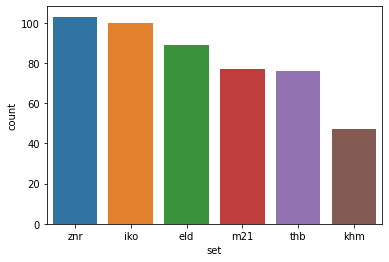

In [26]:
cards_by_set(main_decks,unique_cards=True)

In [27]:
def sort_by_date(df):
    date_order = []
    for year in ["2020", "2021"]:
        for month in [
            "January", "February", "March", "April", 
            "May", "June", "July", "August", 
            "September", "October", "November", "December"
        ]:
            date_order.append(f"{month} {year}")
    this_df = df.copy()
    
    this_df["month_year"] = pd.Categorical(
        this_df["date"].dt.month_name() + " " + (this_df["date"].dt.year).astype("str"),
        date_order,
        ordered=True
    )
    
    this_df["day"] = this_df["date"].dt.day
    
    return this_df.sort_values(by=["month_year", "day"])

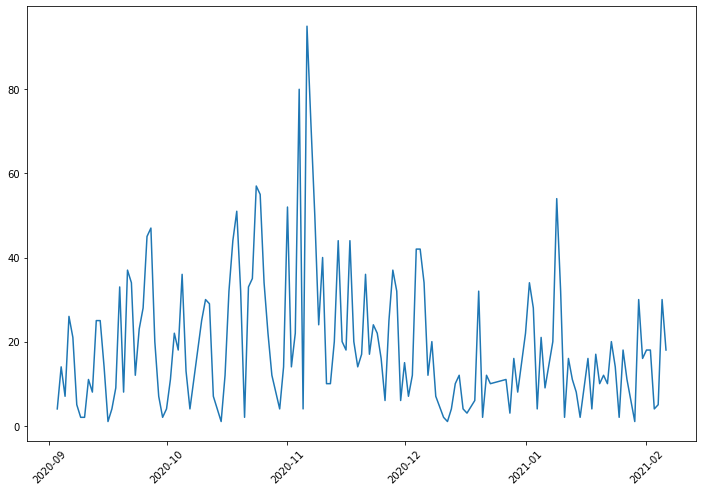

In [28]:
def number_of_decks_over_time(df):
    this_df = sort_by_date(df)
    grouped_df= (
        this_df
        .groupby(["date"])["deckId"]
        .nunique()
        .reset_index()
    )
    
    plt.figure(figsize=(12, 8))
    plt.plot(grouped_df["date"], grouped_df["deckId"])
    plt.xticks(rotation=45)
    plt.show()
    
    
number_of_decks_over_time(full_table)

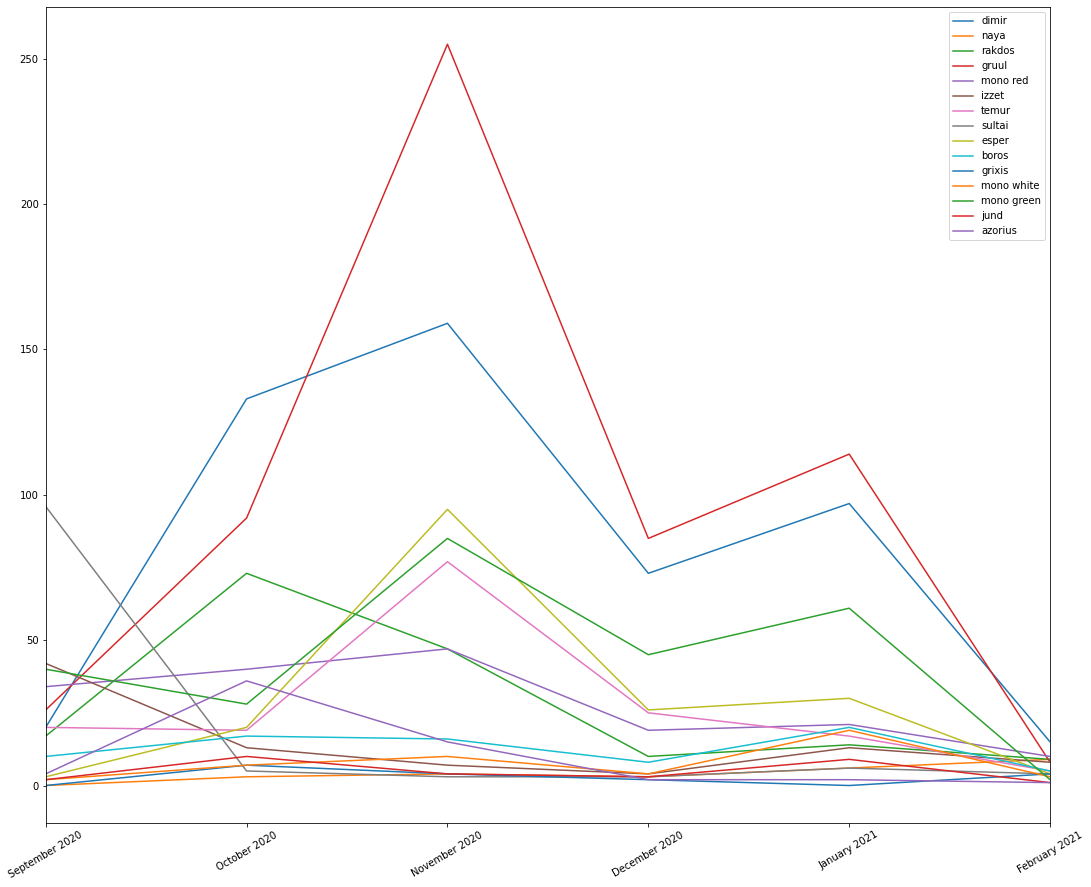

In [29]:
def categories_over_time(df):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "category"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_categories = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["category"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for cat in top_categories:
        cat_df = grouped_df[grouped_df["category"]==cat]
        plt.plot(cat_df["month_year"], cat_df["deckId"], label=cat)
    
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.legend()
    plt.show()
    
categories_over_time(full_table)

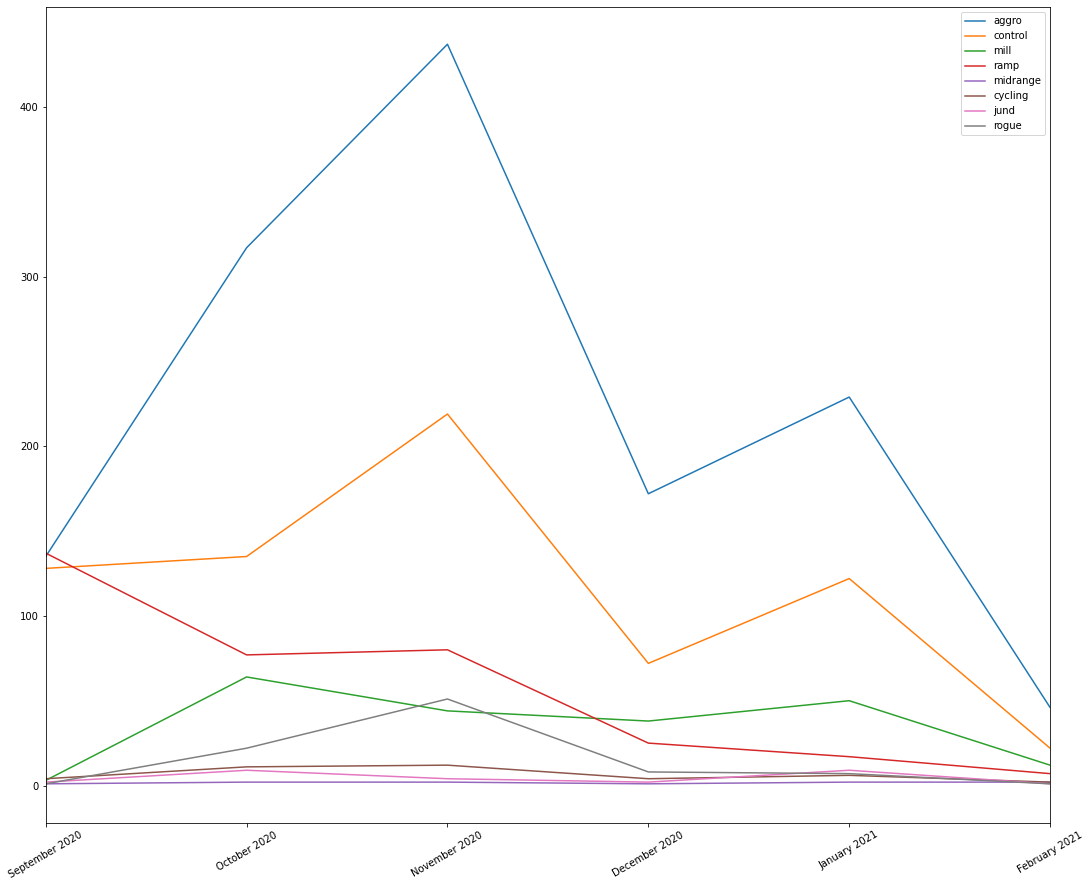

In [30]:
def archetypes_over_time(df):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "archetype"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_archetypes = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["archetype"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for archetype in top_archetypes:
        archetype_df = grouped_df[grouped_df["archetype"]==archetype]
        plt.plot(archetype_df["month_year"], archetype_df["deckId"], label=archetype)
    
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.legend()
    plt.show()
    
archetypes_over_time(full_table)

In [31]:
def arena_vs_nonarena(df):
    this_df = df.copy()
    this_df["is_arena"] = df.apply(lambda x: "arena" if "arena" in x["name_event"].lower() else "not_arena", axis=1)
    arena_freq = pd.crosstab(this_df["archetype"], this_df["is_arena"])
    _, pval, _, _ = chi2_contingency(arena_freq)
    return pval
    

In [32]:
arena_vs_nonarena(full_table)

3.447749119418968e-159

In [33]:
masked_table = full_table.copy()

In [34]:
cat_count = masked_table["category"].value_counts()

In [35]:
cat_count

gruul         14388
dimir         13815
mono green     6208
esper          6090
4-color        6036
rakdos         4598
temur          4347
sultai         3695
mono red       3443
izzet          2480
boros          1886
azorius        1862
golgari        1470
selesnya       1358
mono white     1005
jund            859
mono black      800
abzan           717
naya            671
grixis          498
orzhov          437
jeskai          392
bant            295
simic           268
mono blue       165
mardu           135
colorless        94
5-color          43
Name: category, dtype: int64

In [36]:
mask = masked_table["category"].isin(cat_count[cat_count < 2000].index)

In [37]:
mask

0        False
1        False
2        False
3        False
4        False
         ...  
78050     True
78051     True
78052     True
78053     True
78054     True
Name: category, Length: 78055, dtype: bool

In [38]:
masked_table["category"][mask] = "other"

<ipython-input-38-367f14b33268>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_table["category"][mask] = "other"


In [39]:
masked_table

,eventId,name_event,date,deckId,pilotId,name_deck,firstName,lastName,cardId,name,count,color,slot,archetype,category,latest_set
0,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,261znr,Cragcrown Pathway // Timbercrown Pathway,4,GR,md,aggro,gruul,Zendikar Rising
1,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,244eld,Fabled Passage,4,NaN,md,aggro,gruul,Zendikar Rising
2,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,266eld,Forest,9,G,md,aggro,gruul,Zendikar Rising
3,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,262eld,Mountain,5,R,md,aggro,gruul,Zendikar Rising
4,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,115eld,Bonecrusher Giant // Stomp,4,R,md,aggro,gruul,Zendikar Rising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78050,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,147thb,Ox of Agonas,3,R,sb,control,other,Kaldheim
78051,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,058eld,Mystical Dispute,3,U,sb,control,other,Kaldheim
78052,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,096m21,Duress,4,B,sb,control,other,Kaldheim
78053,559,Free FNM at Home - Bo1 @ Owl Central Games,2021-02-05,2916,1386,Grixis Control,Adam,Bowles,088iko,Extinction Event,3,B,sb,control,other,Kaldheim


In [40]:
masked_table["category"].value_counts()

gruul         14388
dimir         13815
other         12955
mono green     6208
esper          6090
4-color        6036
rakdos         4598
temur          4347
sultai         3695
mono red       3443
izzet          2480
Name: category, dtype: int64

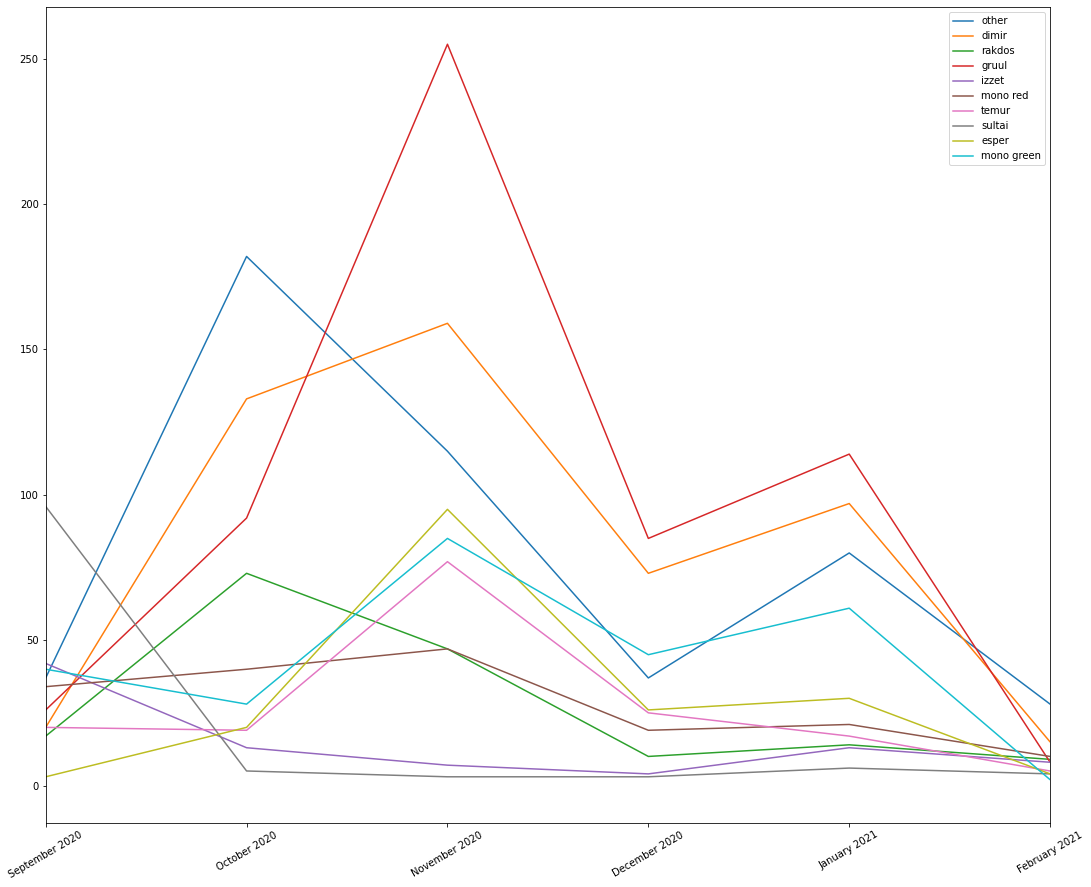

In [41]:
categories_over_time(masked_table)

In [52]:
def color_dominance(df, color):
    this_df = df.copy().fillna("")
    color_cards = this_df[
        (this_df["color"].str.contains(color))
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    sns.barplot(data=color_cards, x="name", y="count")
    plt.xticks(rotation=90)
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.title(f"Most Used {color.title()} Cards")
    plt.show()

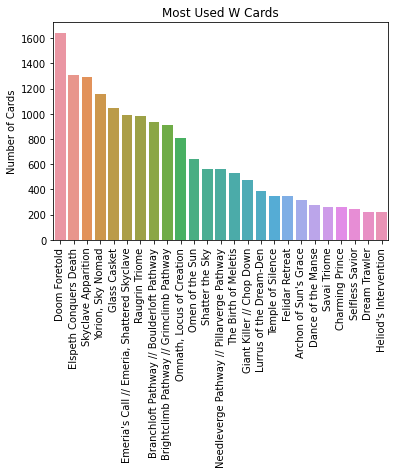

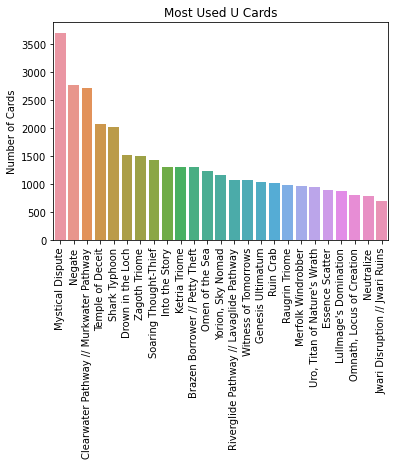

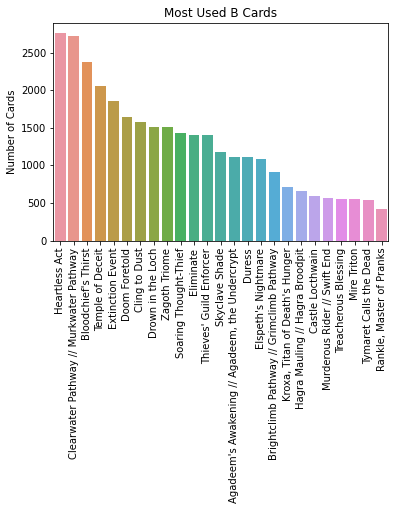

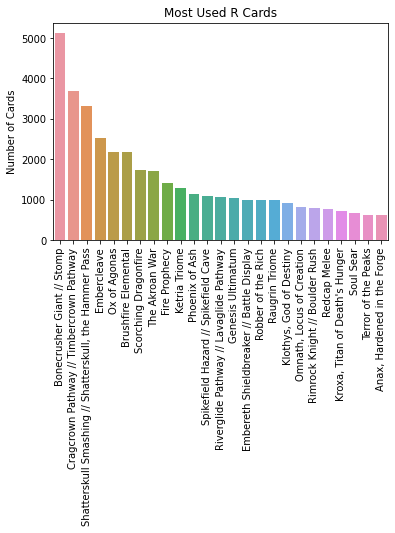

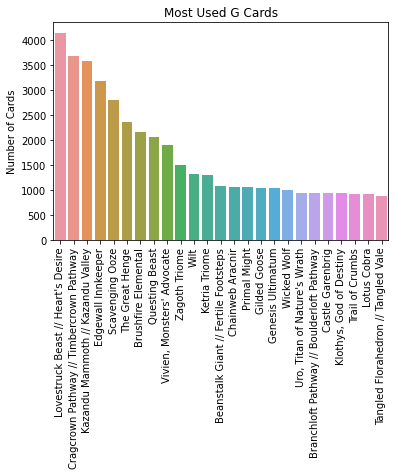

In [53]:
for color in ["W", "U", "B", "R", "G"]:
    color_dominance(full_table, color)

In [55]:
def set_dominance(df, set_code):
    this_df = df.copy().fillna("")
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    set_df = this_df[
        (this_df["set"] == set_code)
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
        & (~this_df["name"].str.contains("Snow-Covered"))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    sns.barplot(data=set_df, x="name", y="count")
    plt.xticks(rotation=90)
    plt.title(f"Most Used Cards from {set_code.title()} Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.show()

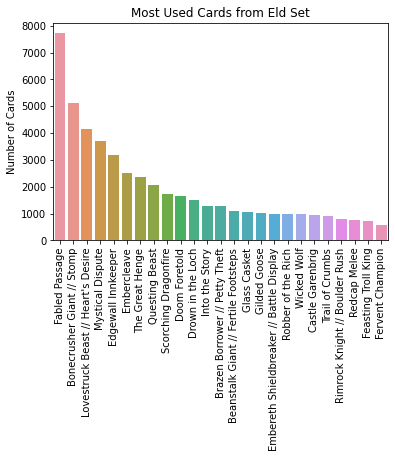

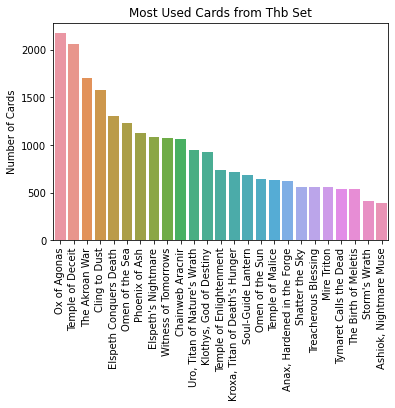

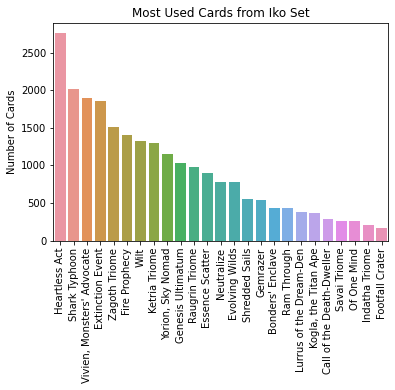

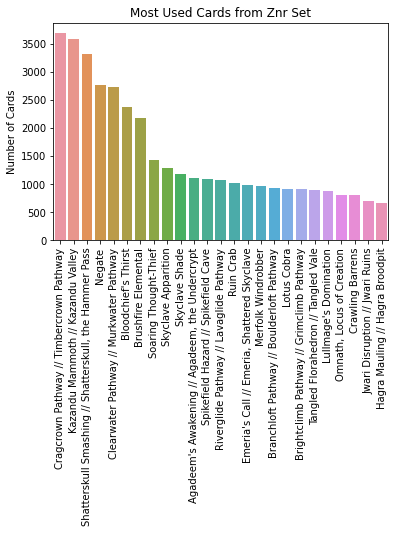

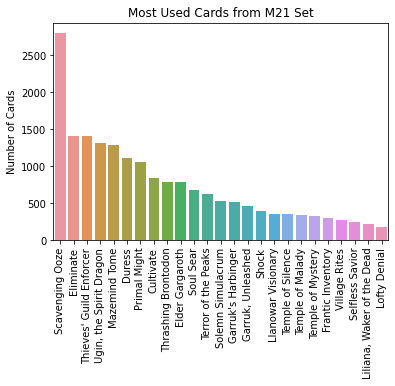

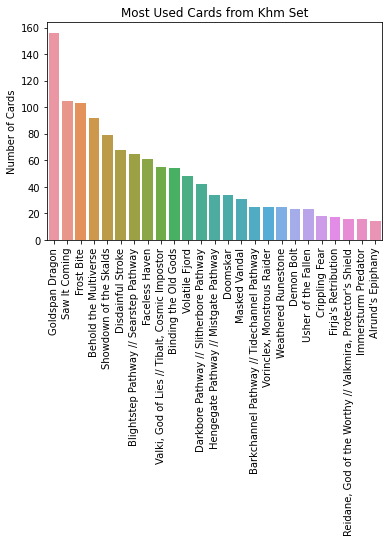

In [56]:
for set_code in ["eld", "thb", "iko", "znr", "m21", "khm"]:
    set_dominance(full_table, set_code)

In [74]:
def oracle_text_analysis():
    df = (
        most_used_cards[["name", "pct_total"]]
        .merge(card_table[["name", "oracle_text"]], on="name", how="left")
        .drop_duplicates()
        .copy()
    )
    return df

In [75]:
oracle_texts = oracle_text_analysis()

In [76]:
oracle_texts

,name,pct_total,oracle_text
0,Fabled Passage,0.690835,"{T}, Sacrifice Fabled Passage: Search your library for a basic land card, put it onto the battlefield tapped, then shuffle your library. Then if you control four or more lands, untap that land."
4,Bonecrusher Giant // Stomp,0.445214,"Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target."
6,"Shatterskull Smashing // Shatterskull, the Hammer Pass",0.406110,"Shatterskull Smashing deals X damage divided as you choose among up to two target creatures and/or planeswalkers. If X is 6 or more, Shatterskull Smashing deals twice X damage divided as you choose among them instead. // As Shatterskull, the Hammer Pass enters the battlefield, you may pay 3 life. If you don't, it enters the battlefield tapped.\n{T}: Add {R}."
8,Lovestruck Beast // Heart's Desire,0.380041,Lovestruck Beast can't attack unless you control a 1/1 creature. // Create a 1/1 white Human creature token. (Then exile this card. You may cast the creature later from exile.)
10,Kazandu Mammoth // Kazandu Valley,0.373116,"Landfall — Whenever a land enters the battlefield under your control, Kazandu Mammoth gets +2/+2 until end of turn. // Kazandu Valley enters the battlefield tapped.\n{T}: Add {G}."
12,The Great Henge,0.362118,"This spell costs {X} less to cast, where X is the greatest power among creatures you control.\n{T}: Add {G}{G}. You gain 2 life.\nWhenever a nontoken creature enters the battlefield under your control, put a +1/+1 counter on it and draw a card."
14,Heartless Act,0.319348,Choose one —\n• Destroy target creature with no counters on it.\n• Remove up to three counters from target creature.
16,Cragcrown Pathway // Timbercrown Pathway,0.313238,{T}: Add {R}. // {T}: Add {G}.
18,Scavenging Ooze,0.312831,"{G}: Exile target card from a graveyard. If it was a creature card, put a +1/+1 counter on Scavenging Ooze and you gain 1 life."
21,Embercleave,0.300611,"Flash\nThis spell costs {1} less to cast for each attacking creature you control.\nWhen Embercleave enters the battlefield, attach it to target creature you control.\nEquipped creature gets +1/+1 and has double strike and trample.\nEquip {3}"
